### Load Libraries and Data

In [1]:
from stable_baselines3 import PPO

from pipeline.test import *
from utils.variables import *
from utils.dhandle import load_data

data = load_data(dataset_path)
model = PPO.load("misc/models/model")

nRecords = len(data[0])
test_size = int(0.2 * nRecords)
channel = 0  # Channel to test on
test_indices_start = nRecords - test_size

data_clean = data[channel][test_indices_start:]
data_noisy = data[channel][test_indices_start:]
for i, data_noisy_i in enumerate(data_noisy):
    data_noisy[i] = add_baseline_wander(data_noisy_i, bw)


Dataset already exists. Loading...


### Infer on test data

In [2]:
n = 50  # Test record number
test_data = data_noisy[n]
ground_truth = data_clean[n]
test_env = NoisyECGEnvironment(
    noisy_signal=test_data,  # Pre-noisy signal
    channel_data=data_clean,  # Clean ECG for reward comparison
    train_indices=[0],
    baseline_wander=None,
    window_seconds=5,
    fs=fs,
    snr_db=10
)
episode_rewards, fc_values, filtered_signals, clean_signals, noisy_signals = run_inference_on_ecg(model, test_env)

/Users/masoud/Documents/Education/Courses/BMI-539/BMI539_venv/lib/python3.10/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/masoud/Documents/Education/Courses/BMI-539/BMI539_venv/lib/python3.10/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


### Results

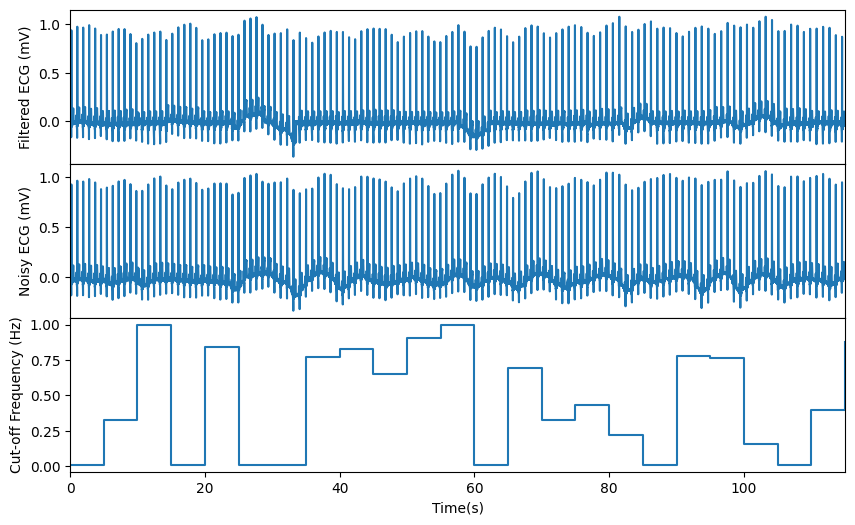

In [3]:
import matplotlib.pyplot as plt
t = np.arange(0, len(test_data)/fs, 1/fs)
t_fc = np.arange(0, t[-1], 5)[:-1]
filtered_signal = np.concatenate(filtered_signals)

# Prepare data for zero-order hold
zoh_time = []
zoh_values = []

for i in range(len(fc_values)):
    if i < len(fc_values) - 1:
        zoh_time.extend([t_fc[i], t_fc[i + 1]])
        zoh_values.extend([fc_values[i], fc_values[i]])
    else:
        zoh_time.append(t_fc[i])
        zoh_values.append(fc_values[i])



plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(t[:len(filtered_signal)], filtered_signal)
plt.ylabel('Filtered ECG (mV)', fontsize=10)
plt.xlim((t[0], t[len(filtered_signal)]))
plt.xticks([])

plt.subplot(3, 1, 2)
plt.plot(t, test_data, label='Noisy ECG')
plt.ylabel('Noisy ECG (mV)', fontsize=10)
plt.xticks([])
plt.xlim((t[0], t[-1]))

plt.subplot(3, 1, 3)
plt.ylabel('Cut-off Frequency (Hz)', fontsize=10)
plt.xlabel('Time(s)', fontsize=10)
plt.step(zoh_time, zoh_values, where='post')
plt.subplots_adjust(hspace=0)
plt.xlim((zoh_time[0], zoh_time[-1]))
plt.show()
